# Per-pixel regression of tide heights vs. MNDWI

**What does this notebook do?** 

This notebook computes pixel-wise regression based on Landsat 5, 7 and 8 MNDWI values (a wetness index) vs tide heights generated using the ([OSU Tidal Prediction Software or OTPS](http://volkov.oce.orst.edu/tides/otps.html)). This results in covariance, correlation, p-value, intercept, slope and standard error values for every pixel in a study area that help reveal how well tidal processes influence patterns of innundation in the landscape.

This workflow can be adapted to comparing the relationship between any remotely sensed metric with another explanatory variable. Because the regression outputs are calculated for every individual pixel, these metrics can then be plotted to reveal spatial patterns in relationships between the two variables.

**Requirements:** 

You need to run the following commands from the command line prior to launching jupyter notebooks from the same terminal so that the required libraries and paths are set:

`module use /g/data/v10/public/modules/modulefiles` 

`module load dea`

`module load otps`

If you find an error or bug in this notebook, please either create an 'Issue' in the Github repository, or fix it yourself and create a 'Pull' request to contribute the updated notebook back into the repository (See the repository [README](https://github.com/GeoscienceAustralia/dea-notebooks/blob/master/README.rst) for instructions on creating a Pull request).

**Date:** October 2018

**Authors:** Robbi Bishop-Taylor, Bex Dunn

## Import modules

In [1]:
# Get standard libraries
from datetime import datetime, timedelta
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import os
import pandas as pd
import sys
import xarray as xr

# Get DEA modules
import datacube
from datacube.utils import geometry
from datacube.utils.geometry import CRS
from otps import TimePoint
from otps import predict_tide

# Import external functions from dea-notebooks using relative link to Scripts
sys.path.append('../10_Scripts')
import DEAPlotting
import DEADataHandling
import BandIndices

%load_ext autoreload
%autoreload 2

# Create datacube instance
dc = datacube.Datacube(app='Tidal regression')

### Define notebook-specific functions

In [8]:
def lag_linregress_3D(x, y, lagx=0, lagy=0, first_dim='time'):
    
    """
    Takes two xr.Datarrays of any dimensions (input data could be a 1D time series, or for example, have 
    three dimensions e.g. time, lat, lon), and return covariance, correlation, regression slope and intercept, 
    p-value, and standard error on regression between the two datasets along their aligned first dimension.  
    
    Datasets can be provided in any order, but note that the regression slope and intercept will be calculated
    for y with respect to x.
    
    Parameters
    ----------    
    x, y : xarray DataArray
        Two xarray DataArrays with any number of dimensions, both sharing the same first dimension
    lagx, lagy : int, optional
        Optional integers giving lag values to assign to either of the data, with lagx shifting x, and lagy 
        shifting y with the specified lag amount. 
    first_dim : str, optional
        An optional string giving the name of the first dimension on which to align datasets. The default is
        'time'.
    
    Returns
    -------
    cov, cor, slope, intercept, pval, stderr : xarray DataArray
        Covariance, correlation, regression slope and intercept, p-value, and standard error on 
        regression between the two datasets along their aligned first dimension.  

    """ 
    
    #1. Ensure that the data are properly alinged to each other. 
    x, y = xr.align(x, y)
    
    #2. Add lag information if any, and shift the data accordingly
    if lagx != 0:
        
        # If x lags y by 1, x must be shifted 1 step backwards. But as the 'zero-th' value is nonexistant, xr 
        # assigns it as invalid (nan). Hence it needs to be dropped:
        x = x.shift(**{first_dim: -lagx}).dropna(dim=first_dim)
        
        # Next re-align the two datasets so that y adjusts to the changed coordinates of x:
        x,y = xr.align(x, y)

    if lagy!=0:
        
        y = y.shift(**{first_dim: -lagy}).dropna(dim=first_dim)
        x, y = xr.align(x, y)
 
    #3. Compute data length, mean and standard deviation along time axis for further use: 
    n = y.notnull().sum(dim=first_dim)
    xmean = x.mean(axis=0)
    ymean = y.mean(axis=0)
    xstd = x.std(axis=0)
    ystd = y.std(axis=0)
    
    #4. Compute covariance along first axis
    cov = np.sum((x - xmean) * (y - ymean), axis=0) / (n)
    
    #5. Compute correlation along time axis
    cor = cov / (xstd * ystd)
    
    #6. Compute regression slope and intercept:
    slope = cov / (xstd**2)
    intercept = ymean - xmean*slope  
    
    #7. Compute P-value and standard error
    #Compute t-statistics
    tstats = cor*np.sqrt(n - 2) / np.sqrt(1 - cor**2)
    stderr = slope/tstats
    
    from scipy.stats import t
    pval = t.sf(tstats, n - 2) * 2
    pval = xr.DataArray(pval, dims=cor.dims, coords=cor.coords)

    return cov, cor, slope, intercept, pval, stderr


## Set up query parameters
Set the centroid and buffer in metres around the centroid to define the analysis region.

In [2]:
# Set up analysis data query
lat, lon, buffer_x, buffer_y = -12.463, 130.885, 3500, 3500  # Darwin Harbour
# lat, lon, buffer_x, buffer_y = -12.265, 132.273, 3500, 8000  # Alligator
# lat, lon, buffer_x, buffer_y = -14.809, 135.357, 5000, 4000 # Roper River

# Set a tide post: this is the location the OTPS model uses to compute tides for the supplied datetimes/
# This can usually be set to be the same as lat and lon above, but this fails if lat and lon
# fall over land where the model cannot compute tide heights
tidepost_lat, tidepost_lon = -12.48315, 130.85540  # Darwin Harbour
# tidepost_lat, tidepost_lon = -12.1982891466, 132.284149706  # Alligator
# tidepost_lat, tidepost_lon = -14.8051364068, 135.453025279  # Roper River

## Import remotely-sensed time series data
Imports a time series of Landsat observations as a DEA `xarray` dataset.

Loading ls5 pixel quality
    Loading 189 filtered ls5 timesteps
Ignoring SLC-off observations for ls7
Loading ls7 pixel quality
    Loading 65 filtered ls7 timesteps
Loading ls8 pixel quality
    Loading 93 filtered ls8 timesteps
Combining and sorting ls5, ls7, ls8 data
    Replacing invalid -999 values with NaN (data will be coerced to float64)


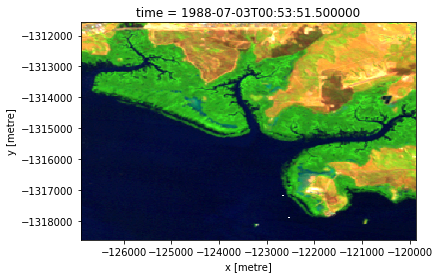

In [3]:
# Set up query
x, y = geometry.point(lon, lat, CRS('WGS84')).to_crs(CRS('EPSG:3577')).points[0]
query = {'x': (x - buffer_x, x + buffer_x),
         'y': (y - buffer_y, y + buffer_y),         
         'crs': 'EPSG:3577',
         'time': ('1986-01-01', '2019-01-01')}

# Mask used to identify bad pixels (any cloudy, shadowey or saturated pixels)
mask_dict = {'cloud_acca': 'no_cloud', 
             'cloud_fmask': 'no_cloud', 
             'cloud_shadow_acca':'no_cloud_shadow',
             'cloud_shadow_fmask':'no_cloud_shadow',
             'blue_saturated':False,
             'green_saturated':False,
             'red_saturated':False,
             'nir_saturated':False,
             'swir1_saturated':False,
             'swir2_saturated':False,
             'contiguous': True}

# Import data
data = DEADataHandling.load_clearlandsat(dc=dc, query=query, 
                                         sensors=['ls5', 'ls7', 'ls8'],
                                         mask_dict=mask_dict,
                                         masked_prop=0.2, 
                                         mask_pixel_quality=True)

# Plot sample of the data
data[['swir1', 'nir', 'green']].isel(time=6).to_array().plot.imshow(robust=True)

## Tidal modelling using OTPS
Extracts a list of timestamps based on the time and date of acquisition for each Landsat observation. These timestamps can then be used inputs to the [OSU Tidal Prediction Software (OTPS) tidal model](http://volkov.oce.orst.edu/tides/otps.html) to compute tidal heights at the time of acquisition of each Landsat observation.

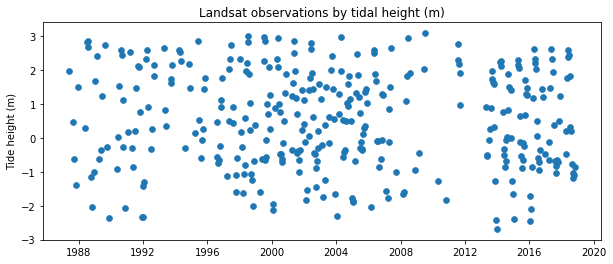

In [5]:
# Extract list of datetimes based on Landsat time of acquisition for each image
observed_datetimes = data.time.data.astype('M8[s]').astype('O').tolist()

# The OTPS model requires inputs as 'TimePoint' objects, which are combinations of lon-lat coordinates 
# and a datetime object. You can create a list of these with a list comprehension:
observed_timepoints = [TimePoint(tidepost_lon, tidepost_lat, dt) for dt in observed_datetimes]

# Feed the entire list of timepoints to the OTPS `predict_tide` function:
observed_predictedtides = predict_tide(observed_timepoints)

# For each of the predicted tide objects, extract a list of tidal heights in `m` units relative to mean 
# sea level (the `tide_m` method should not be confused with the `depth_m` method, which gives you the 
# ocean depth at the tide post location that is used by the OTPS model to predict tides)
observed_tideheights = [predictedtide.tide_m for predictedtide in observed_predictedtides]

# Create a dataframe of tidal heights for each Landsat observation
observed_df = pd.DataFrame({'tide_height': observed_tideheights}, 
                           index=pd.DatetimeIndex(observed_datetimes))

# Plot tidal heights against Landsat observation date
fig, ax = plt.subplots(figsize=(10, 4))
ax.scatter(observed_df.index, observed_df.tide_height, linewidth=0.6, zorder=1, label='Modelled')
ax.set_title('Landsat observations by tidal height (m)')
ax.set_ylabel('Tide height (m)');


### Tagging, filtering and compositing Landsat observations by tidal height/stage
Adds tidal height data back into our original `xarray` dataset so that each Landsat observation is correctly tagged with its corresponding tidal height. 

To compute regressions between tide heights and MNDWI values, we need to change the dataset's index from time to tide height. As an easy/clunky solution, we can assign our tide heights into the time coordinate, then rename it to tide. Note that because our tide heights contain duplicate values, we need to add tiny random values to our tide heights before assigning them into our time coordinate (xarray indexes cannot include random values).

In [6]:
# Create new tide height variable with one height for every time observation
tide_heights = xr.DataArray(observed_tideheights, [('time', data.time)])
data['tide_heights'] = tide_heights

# Set time axis to tide values and sort; have to add time random fuzz to prevent duplicate indexes
data['time'] = tide_heights + np.random.uniform(low=0.0, high=0.0009, size=len(tide_heights))
data.rename({'time': 'tide'}, inplace=True)
data = data.sortby('tide')
data

<xarray.Dataset>
Dimensions:       (tide: 347, x: 281, y: 281)
Coordinates:
  * y             (y) float64 -1.312e+06 -1.312e+06 ... -1.319e+06 -1.319e+06
  * x             (x) float64 -1.269e+05 -1.269e+05 ... -1.199e+05 -1.199e+05
  * tide          (tide) float64 -2.7 -2.443 -2.41 -2.401 ... 2.973 3.017 3.103
Data variables:
    blue          (tide, y, x) float64 1.636e+03 1.858e+03 ... 605.0 559.0
    green         (tide, y, x) float64 1.944e+03 2.227e+03 ... 661.0 661.0
    red           (tide, y, x) float64 1.971e+03 2.257e+03 ... 303.0 303.0
    nir           (tide, y, x) float64 3.112e+03 3.363e+03 ... 112.0 163.0
    swir1         (tide, y, x) float64 2.942e+03 3.341e+03 ... 24.0 10.0
    swir2         (tide, y, x) float64 2.37e+03 2.684e+03 ... 34.0 34.0
    data_perc     (tide, y, x) float64 0.8646 0.8646 0.8646 ... 0.946 0.946
    tide_heights  (tide) float64 -2.7 -2.444 -2.41 -2.402 ... 2.973 3.017 3.102
Attributes:
    crs:      EPSG:3577

### Compute linear regression of MNDWI vs tide height
First we calculate the Modified Normalised Difference Water Index (MNDWI) for every pixel in the study area, then compare this to tide heights using linear regression. This calculates covariance, correlation, intercept, p-value and standard error for NDWI values vs tide heights for every pixel, which we can plot spatially:


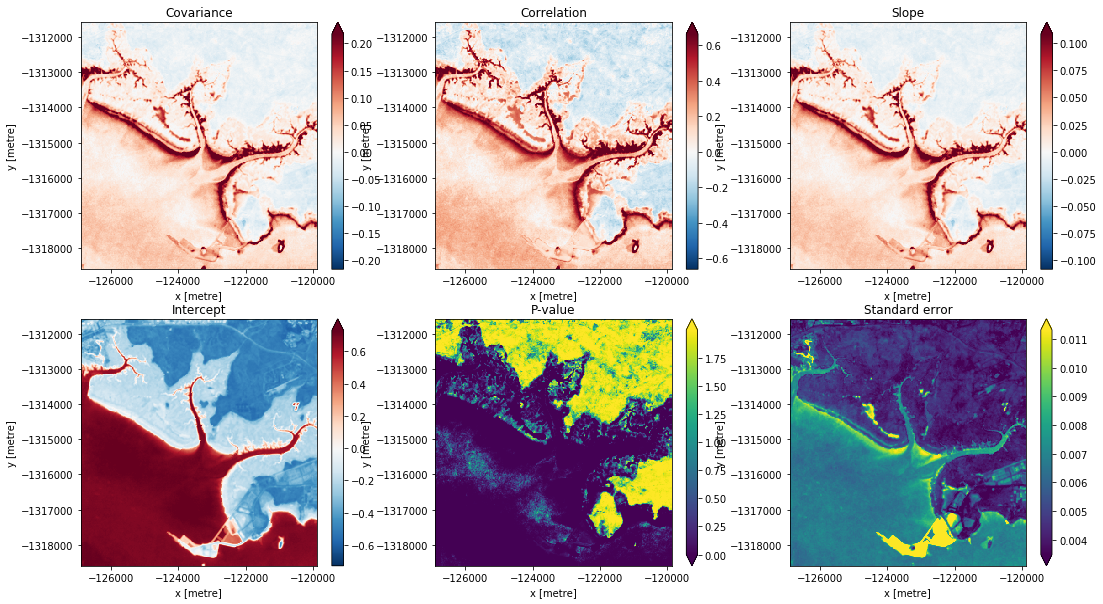

In [9]:
# Calculate metric
data['mndwi'] = (data.green - data.swir1) / (data.green + data.swir1)
# data['ndwi'] = (data.green - data.nir) / (data.green + data.nir)
# data = BandIndices.tasseled_cap(data, tc_bands=['wetness'], drop=False)

# Calculate regression
cov, cor, slope, intercept, pval, stderr = lag_linregress_3D(data['tide_heights'],
                                                             data['mndwi'],
                                                             first_dim='tide')

# Plot all outputs
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(18, 10))
cov.plot(robust=True, ax=ax1)
ax1.set_title('Covariance')
cor.plot(robust=True, ax=ax2)
ax2.set_title('Correlation')
slope.plot(robust=True, ax=ax3)
ax3.set_title('Slope')
intercept.plot(robust=True, ax=ax4)
ax4.set_title('Intercept')
pval.plot(robust=True, ax=ax5)
ax5.set_title('P-value')
stderr.plot(robust=True, ax=ax6)
ax6.set_title('Standard error');


Plot correlation only for pixels where p-value is less than 0.05:

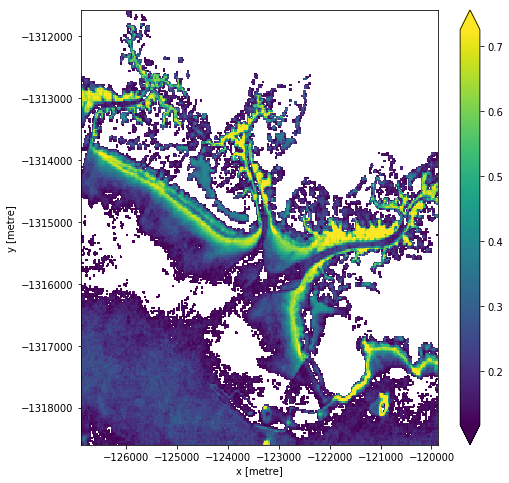

In [10]:
plt.figure(figsize=(8, 8))
cor.where(pval < 0.05).plot(robust=True)

### Scatterplots
For more detailed inspection of the data, we can plot scatterplots of MNDWI values by tide height for a single pixel. The black dot on the MNDWI image on the right gives the location of the point used for the scatterplot:

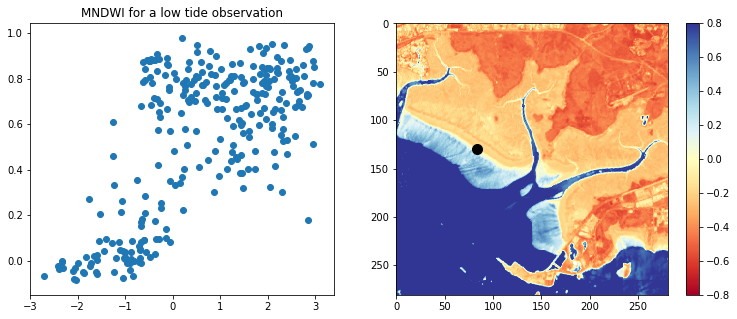

In [15]:
# Change x_ind and y_ind to explore scatterplots for different locations
x_ind, y_ind, tide_ind = 83, 130, 2

# Plot scatterplot
figure, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].scatter(x = data.isel(x=x_ind, y=y_ind).tide_heights, 
                y = data.isel(x=x_ind, y=y_ind).mndwi)
axes[0].set_title("Scatterplot of MNDWI vs tide heights")

# Plot NDWI with point overlay
im = axes[1].imshow(data.isel(tide=tide_ind).mndwi.values, cmap = 'RdYlBu', vmin = -0.8, vmax = 0.8)
axes[1].scatter(x=x_ind, y=y_ind, s=100, c = 'black')
axes[0].set_title("MNDWI for a low tide observation")

# Add colourbar
divider = make_axes_locatable(axes[1])
cax = divider.append_axes('right', size='5%', pad=0.25)
plt.colorbar(im, cax=cax)


## Experimental: test if correlations are higher at various tide height lags
Here we lag tide heights by a set of negative and positive lag amounts, and compare what lags resulted in the highest correlations:

In [4]:
# # Define max amount and steps by which to lag
# max_lag = 10
# by = 1

# # Iterate up to max lag
# lagged_arrays = []
# for i in range(-max_lag, max_lag+1, by):
    
#     # Compute regression, and mask correlation by p-value
#     _, lagged_cor, _, _, lagged_pval, _ = lag_linregress_3D(x=data.tide_heights, y=data.mndwi, lagx=i, first_dim='tide')
#     lagged_arrays.append(lagged_cor.where(lagged_pval < 0.05))

# # Combine into one array with lag dimensions from 0 to max_lag
# lagged_dataarray = xr.concat(lagged_arrays, dim='lag')

# # Determine what lag index had the highest correlation for each pixel, and
# # rename lag indexes to logical values centred around zero (neg and pos lag)
# max_cor_index = lagged_dataarray.fillna(0).argmax(dim='lag')
# max_cor_lag = max_cor_index * by - max_lag

# # Plot result for pixels that have p < 0.05 / NaN for any time step
# plt.figure(figsize=(10, 8))
# all_nan = lagged_dataarray.notnull().max(dim='lag')
# max_cor_lag.where(all_nan).plot(cmap='RdYlBu')     